<a href="https://colab.research.google.com/github/Gulwalishah/CLT/blob/main/Spline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
pip install torch torchvision matplotlib


In [12]:
!python spline_mnist.py



python3: can't open file '/content/spline_mnist.py': [Errno 2] No such file or directory


Using device: cpu
[RELU] Epoch 1/25 | Train Loss: 0.4991, Train Acc: 87.47% | Test Loss: 0.2708, Test Acc: 92.05%
[RELU] Epoch 2/25 | Train Loss: 0.2452, Train Acc: 93.17% | Test Loss: 0.2054, Test Acc: 94.10%
[RELU] Epoch 3/25 | Train Loss: 0.1910, Train Acc: 94.65% | Test Loss: 0.1706, Test Acc: 95.09%
[RELU] Epoch 4/25 | Train Loss: 0.1562, Train Acc: 95.59% | Test Loss: 0.1431, Test Acc: 95.95%
[RELU] Epoch 5/25 | Train Loss: 0.1320, Train Acc: 96.30% | Test Loss: 0.1267, Test Acc: 96.34%
[RELU] Epoch 6/25 | Train Loss: 0.1133, Train Acc: 96.81% | Test Loss: 0.1123, Test Acc: 96.65%
[RELU] Epoch 7/25 | Train Loss: 0.0980, Train Acc: 97.32% | Test Loss: 0.1019, Test Acc: 97.06%
[RELU] Epoch 8/25 | Train Loss: 0.0862, Train Acc: 97.66% | Test Loss: 0.0928, Test Acc: 97.30%
[RELU] Epoch 9/25 | Train Loss: 0.0763, Train Acc: 97.91% | Test Loss: 0.0891, Test Acc: 97.31%
[RELU] Epoch 10/25 | Train Loss: 0.0682, Train Acc: 98.12% | Test Loss: 0.0825, Test Acc: 97.65%
[RELU] Epoch 11/25 | 

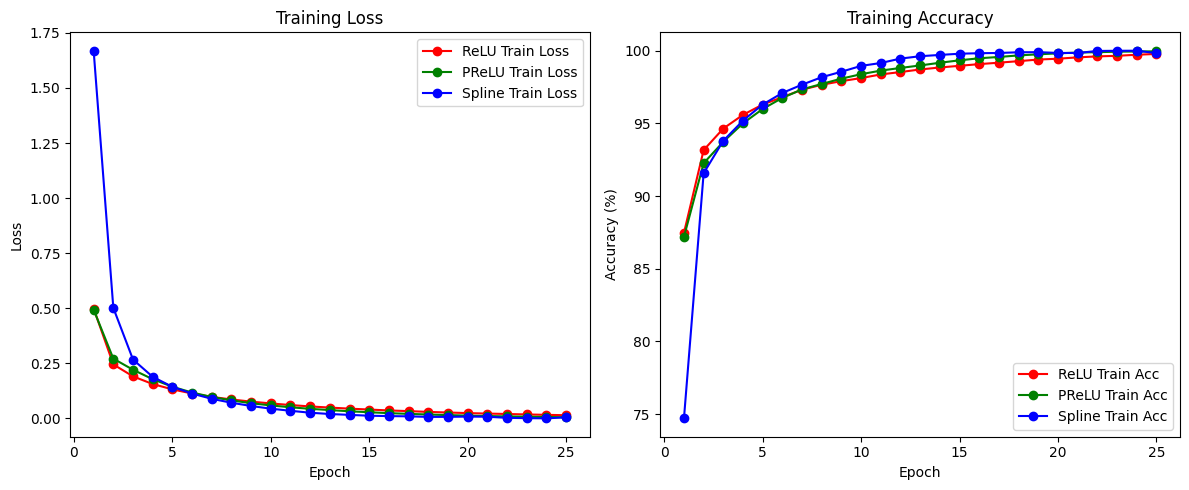

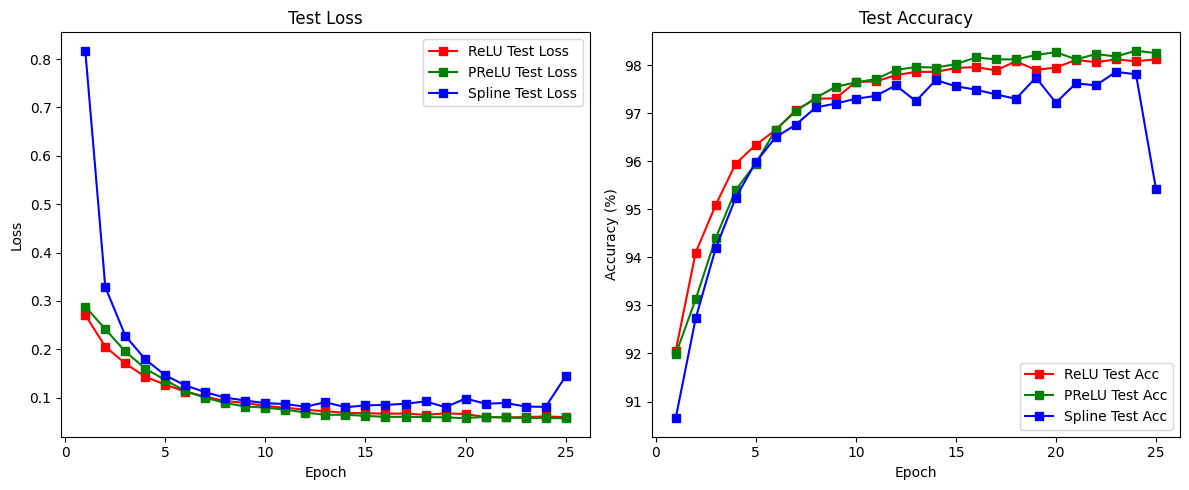

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

###############################################################################
# 1) Define the B-Spline Activation & TV^2 Penalty (for spline only)
###############################################################################
class BSplineActivation(nn.Module):
    """
    1D B-spline (triangular) activation on a uniform grid.
    """
    def __init__(self, num_knots=28, knot_spacing=0.1):#tuning; num_knots 20-40
        super().__init__()
        self.num_knots = num_knots
        self.knot_spacing = knot_spacing

        # Trainable spline coefficients
        ##(Tuning Strategy: Initialize with small random values (e.g., torch.randn(num_knots) * 0.01))
        self.coeffs = nn.Parameter(torch.zeros(num_knots)*0.02)

        # Fixed knot positions
        knots = torch.arange(num_knots) * knot_spacing
        self.register_buffer('knot_positions', knots)

    def forward(self, x):
        # Flatten input for distance calc
        orig_shape = x.shape
        x_flat = x.view(-1)

        x_expanded = x_flat.unsqueeze(-1)               # [N, 1]
        knots_expanded = self.knot_positions.unsqueeze(0)  # [1, K]

        dist = torch.abs(x_expanded - knots_expanded)
        phi = F.relu(1.0 - dist / self.knot_spacing)    # Triangular basis
        out_flat = phi @ self.coeffs                    # [N]

        return out_flat.view(orig_shape)

def tv2_penalty(coeffs):
    """
    2nd-order total variation:
       sum(|c_{k+1} - 2*c_k + c_{k-1}|)
    """
    penalty = 0.0
    for k in range(1, len(coeffs) - 1):
        second_diff = coeffs[k+1] - 2*coeffs[k] + coeffs[k-1]
        penalty += torch.abs(second_diff)
    return penalty

###############################################################################
# 2) Build a Simple Network with a Customizable Activation
###############################################################################
class MyMNISTNet(nn.Module):
    """
    A 2-layer fully connected network for MNIST:
      input_dim -> hidden_dim -> 10
    Activation can be ReLU, PReLU, or BSpline.
    """
    def __init__(self, input_dim=784, hidden_dim=256,
                 activation='relu', num_knots=20, knot_spacing=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Choose the activation
        if activation == 'spline':
            self.activation = BSplineActivation(num_knots, knot_spacing)
        elif activation == 'prelu':
            # PReLU with 1 learnable parameter per activation channel
            self.activation = nn.PReLU(num_parameters=1)
        else:
            # Default: ReLU
            self.activation = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim, 10)
        self.activation_type = activation  # store for reference

    def forward(self, x):
        # x expected shape: [batch_size, 784]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

###############################################################################
# 3) Train & Evaluate Routines
###############################################################################
def train_epoch(model, dataloader, optimizer, device, lambda_tv=1e-3):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.size(0), -1)  # Flatten: [batch, 784]

        optimizer.zero_grad()

        logits = model(images)
        loss_data = F.cross_entropy(logits, labels)

        # If it's a spline activation, add TV^2 penalty
        if getattr(model, 'activation_type', None) == 'spline':
            spline_coeffs = model.activation.coeffs
            penalty = tv2_penalty(spline_coeffs)
            loss = loss_data + lambda_tv * penalty
        else:
            # ReLU or PReLU have no TV^2 penalty
            loss = loss_data

        loss.backward()
        optimizer.step()

        total_loss += loss_data.item() * images.size(0)

        # Accuracy
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)

            logits = model(images)
            loss_data = F.cross_entropy(logits, labels)

            total_loss += loss_data.item() * images.size(0)

            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

###############################################################################
# 4) Helper Function: Run an Experiment with a Specified Activation
###############################################################################
def run_experiment(
    activation='relu',
    lambda_tv=1e-3,
    epochs=5,
    batch_size=64,
    learning_rate=1e-3,
    hidden_dim=256,
    device='cpu',
):
    """
    Builds a MyMNISTNet with the given 'activation' ('relu', 'prelu', or 'spline'),
    trains for 'epochs' on MNIST, and returns lists of [train_loss, test_loss,
    train_acc, test_acc].
    """
    # 1. MNIST Data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=transform, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, transform=transform, download=True
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 2. Model, Optimizer
    model = MyMNISTNet(
        activation=activation,
        hidden_dim=hidden_dim
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 3. Training Loop
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(1, epochs+1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, lambda_tv)
        test_loss, test_acc = evaluate(model, test_loader, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"[{activation.upper()}] Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    return train_losses, test_losses, train_accs, test_accs

###############################################################################
# 5) Main: Compare ReLU, PReLU, and B-Spline
###############################################################################
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    # Common hyperparameters
    EPOCHS = 25
    BATCH_SIZE = 64
    ##Increase beyond 1e-3 if the spline seems to overfit (e.g., training accuracy goes up but test accuracy lags)
    LEARNING_RATE = 1e-4
    HIDDEN_DIM = 256

    # We'll run three experiments:
    #  1) ReLU    (no TV penalty)
    #  2) PReLU   (no TV penalty)
    #  3) Spline  (with TV penalty)
    # Adjust lambda_tv if you want a stronger/weaker smoothing effect
    ###(Try lambda_tv = 1e-4 or 1e-5 if you see the spline is too constrained (accuracy is low, shape is too flat))
    LAMBDA_TV = 1e-4

    # 1) ReLU
    relu_results = run_experiment(
        activation='relu',
        lambda_tv=0.0,  # no penalty for ReLU
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        hidden_dim=HIDDEN_DIM,
        device=device
    )

    # 2) PReLU
    prelu_results = run_experiment(
        activation='prelu',
        lambda_tv=0.0,  # no penalty for PReLU
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        hidden_dim=HIDDEN_DIM,
        device=device
    )

    # 3) B-Spline
    spline_results = run_experiment(
        activation='spline',
        lambda_tv=LAMBDA_TV,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        hidden_dim=HIDDEN_DIM,
        device=device
    )

    # Unpack the results
    relu_train_losses, relu_test_losses, relu_train_accs, relu_test_accs = relu_results
    prelu_train_losses, prelu_test_losses, prelu_train_accs, prelu_test_accs = prelu_results
    spline_train_losses, spline_test_losses, spline_train_accs, spline_test_accs = spline_results

    #------------------------------------------------------------------------------
    # PLOT: Training Loss and Accuracy
    #------------------------------------------------------------------------------
    epochs_range = range(1, EPOCHS+1)

    plt.figure(figsize=(12, 5))
    # (A) Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, relu_train_losses,   'r-o', label='ReLU Train Loss')
    plt.plot(epochs_range, prelu_train_losses,  'g-o', label='PReLU Train Loss')
    plt.plot(epochs_range, spline_train_losses, 'b-o', label='Spline Train Loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # (B) Training Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, relu_train_accs,   'r-o', label='ReLU Train Acc')
    plt.plot(epochs_range, prelu_train_accs,  'g-o', label='PReLU Train Acc')
    plt.plot(epochs_range, spline_train_accs, 'b-o', label='Spline Train Acc')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    #------------------------------------------------------------------------------
    # PLOT: Test Loss and Accuracy
    #------------------------------------------------------------------------------
    plt.figure(figsize=(12, 5))
    # (A) Test Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, relu_test_losses,   'r-s', label='ReLU Test Loss')
    plt.plot(epochs_range, prelu_test_losses,  'g-s', label='PReLU Test Loss')
    plt.plot(epochs_range, spline_test_losses, 'b-s', label='Spline Test Loss')
    plt.title("Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # (B) Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, relu_test_accs,   'r-s', label='ReLU Test Acc')
    plt.plot(epochs_range, prelu_test_accs,  'g-s', label='PReLU Test Acc')
    plt.plot(epochs_range, spline_test_accs, 'b-s', label='Spline Test Acc')
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
